In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

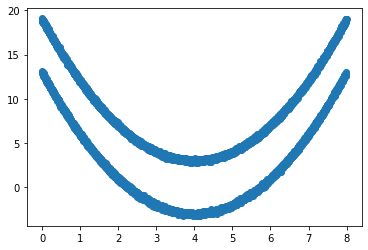

In [2]:
X = np.random.uniform(0, 8, 10000)
U = np.random.uniform(0, 1, 10000)
N1 = np.random.normal(3, 0.1, 10000)
N2 = np.random.normal(-3, 0.1, 10000)
Z = (X-4) ** 2
Z[U >= 0.5] = Z[U >= 0.5] + N1[U >= 0.5]
Z[U < 0.5] = Z[U < 0.5] + N2[U <= 0.5]
fig, ax = plt.subplots(1,1)
ax.scatter(X,Z)

In [3]:
L = np.zeros(10000)
mask = Z >= (X-4) ** 2 
L[mask] = 1
L[~mask] = 0

idx = np.random.permutation(np.arange(0,10000))
X_train = X[idx[0:int(0.8*10000)]]
X_test = X[idx[int(0.8*10000):]]

Z_train = Z[idx[0:int(0.8*10000)]]
Z_test = Z[idx[int(0.8*10000):]]

L_train = L[idx[0:int(0.8*10000)]]
L_test = L[idx[int(0.8*10000):]]

X_final_train = np.zeros((X_train.shape[0],2))
X_final_train[:,0] = X_train
X_final_train[:,1] = Z_train

X_final_test = np.zeros((X_test.shape[0],2))
X_final_test[:,0] = X_test
X_final_test[:,1] = Z_test

print(X_final_train.shape)
print(X_final_test.shape)

(8000, 2)
(2000, 2)


In [4]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [5]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        super().__init__()
        self.X = X
        self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx,:], self.Y[idx]

In [36]:
training_set = CustomDataset(X_final_train, L_train)

In [37]:
len(training_set)

8000

In [38]:
training_set.__len__()

8000

In [39]:
training_set[0]

(array([ 7.96963561, 18.50559097]), 1.0)

In [40]:
X_final_train[0,:]

array([ 7.96963561, 18.50559097])

In [41]:
L_train[0]

1.0

In [12]:
training_set.__getitem__(0)

(array([ 7.96963561, 18.50559097]), 1.0)

In [13]:
test_set = CustomDataset(X_final_test, L_test)

In [14]:
training_dataloader = DataLoader(training_set, batch_size=512, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=512, shuffle=True)

In [15]:
len(training_dataloader)

16

In [16]:
8000 / 512 # (dataset size / batch_size)

15.625

In [17]:
batch_example = next(iter(training_dataloader))

In [18]:
batch_example[0].shape

torch.Size([512, 2])

In [19]:
batch_example[1].shape

torch.Size([512])

In [20]:
numpy_example = np.array([[1,2,3,4],[5,6,7,8]])

In [21]:
numpy_example

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [22]:
torch_example = torch.Tensor([[1,2,3,4],[5,6,7,8]])

In [23]:
torch_example

tensor([[1., 2., 3., 4.],
        [5., 6., 7., 8.]])

In [24]:
torch_example.numpy()

array([[1., 2., 3., 4.],
       [5., 6., 7., 8.]], dtype=float32)

In [25]:
class NNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_1 = torch.nn.Linear(in_features=2, out_features=10, bias=True)
        self.sigmoid_1 = torch.nn.Sigmoid()
        self.linear_2 = torch.nn.Linear(in_features=10, out_features=20, bias=True)
        self.sigmoid_2 = torch.nn.Sigmoid()
        self.linear_3 = torch.nn.Linear(in_features=20, out_features=1, bias=True)
        self.sigmoid_3 = torch.nn.Sigmoid()
    
    def forward(self, x):
        #print(f"x.shape = {x.shape}")       # 512 x 2
        z1 = self.linear_1(x)
        #print(f"z1.shape = {z1.shape}")     # 512 x 10
        a1 = self.sigmoid_1(z1)
        #print(f"a1.shape = {a1.shape}")     # 512 x 10
        z2 = self.linear_2(a1)
        #print(f"z2.shape = {z2.shape}")     # 512 x 20
        a2 = self.sigmoid_2(z2)
        #print(f"a2.shape = {a2.shape}")     # 512 x 20
        z3 = self.linear_3(a2)
        #print(f"z3.shape = {z3.shape}")     # 512 x 1 -> -inf, +inf -> logit 
        y = self.sigmoid_3(z3)
        #print(f"y.shape = {y.shape}")       # 512 x 1 -> [0, 1]
        return y

In [26]:
nnet = NNet()

In [27]:
print(nnet)

NNet(
  (linear_1): Linear(in_features=2, out_features=10, bias=True)
  (sigmoid_1): Sigmoid()
  (linear_2): Linear(in_features=10, out_features=20, bias=True)
  (sigmoid_2): Sigmoid()
  (linear_3): Linear(in_features=20, out_features=1, bias=True)
  (sigmoid_3): Sigmoid()
)


In [28]:
criterion = torch.nn.BCELoss(reduction='sum') # criterion, is my lost function
optimizer = torch.optim.SGD(nnet.parameters(), lr=0.001) # is my optimizer

In [29]:
# Now I have:
# dataset -> ok
# model -> 3 linear layers with sigmod as activation
# loss/criterion as Binary Cross Entropy
# optimizar as SGD (supports mini-batch)
torch.cuda.is_available()

False

In [30]:
device = ""
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

nnet.to(device)

for epoch in range(100):

    running_loss = 0
    for i, data in enumerate(training_dataloader):

        # batch
        x, y = data
        x = x.to(device).float()
        y = y.to(device).float().reshape(-1,1)

        # set gradient to zero
        optimizer.zero_grad()

        # forward 
        y_hat = nnet(x)

        # loss
        loss = criterion(y_hat, y)

        # backward
        loss.backward()

        # update of parameters
        optimizer.step()

        # compute metrics and statistics
        running_loss += loss.item()
    
    if epoch%10 == 0:
      print(f"Epoch = {epoch} | loss = {running_loss / len(training_set)}")

Epoch = 0 | loss = 0.6792923316955567
Epoch = 10 | loss = 0.4469613037109375
Epoch = 20 | loss = 0.43607654571533205
Epoch = 30 | loss = 0.42582862663269044
Epoch = 40 | loss = 0.40778655433654787
Epoch = 50 | loss = 0.3774983701705933
Epoch = 60 | loss = 0.34194770431518556
Epoch = 70 | loss = 0.34689538288116456
Epoch = 80 | loss = 0.29782953071594237
Epoch = 90 | loss = 0.29567039394378664


In [31]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = np.zeros((len(test_dataloader)))
precision = np.zeros((len(test_dataloader)))
recall = np.zeros((len(test_dataloader)))
f1 = np.zeros((len(test_dataloader)))

for i, data in enumerate(test_dataloader):
    # compute metrics (precision, recall, acc, f1) | use scikit learn
    x, y = data
    x = x.to(device).float()
    y = y.to(device).float().reshape(-1,1)

    # forward
    y_hat = nnet(x).detach().numpy() > 0.5

    # metrics
    accuracy[i] = accuracy_score(y, y_hat)
    precision[i] = precision_score(y, y_hat)
    recall[i] = recall_score(y, y_hat)
    f1[i] = f1_score(y, y_hat)
   
print("Accuracy: " + str(accuracy.mean()))  
print("Precision: " + str(precision.mean()))
print("Recall: " + str(recall.mean()))
print("F1_score: " + str(f1.mean()))

Accuracy: 0.9203091325431034
Precision: 0.8616131702298251
Recall: 1.0
F1_score: 0.9255983646133675
